## ABSA analysis on subset (timestamp >= 2023-05-01)
4892 rows

Aspect-Based Sentiment Analysis (ABSA), also known as fine-grained opinion mining, is the task of determining the sentiment of a text with respect to a specific aspect.

1. Identify core text feature aspects via ABSA
2. Temporal changes in aspects over time
3. Store-wise comparison
4. RQ1: Which text feature aspects most strongly influence star ratings
5. RQ2: Which text feature aspects mostly predict review helpfulness(0-1 binary)

| Feature Group                | What it captures                     | Why it matters              |
| ---------------------------- | ------------------------------------ | --------------------------- |
| **Aspect Sentiment scores**  | Per-aspect polarity & intensity      | Main predictors for RQs     |
| **Aspect Mentions (binary)** | Which aspects are discussed          | Controls for omission bias  |
| **Review metadata**          | Rating, helpful votes, verified | Targets + confound controls |
| **Product identifiers**      | Category, brand, ASIN                | Clustering / fixed effects  |


#### 1. Aspect cleaning based on former result

In [52]:
import pandas as pd
import numpy as np

In [53]:
df = pd.read_csv('../data/subset_absa_result.csv')

In [54]:
df

,Unnamed: 0,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence
0,0,I ordered this short - sleeve shirt in white i...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['I', 'ordered', 'this', 'short', '-', 'sleeve...","['fits', 'material', 'fit']","[[26], [69], [76]]","['Positive', 'Positive', 'Positive']","[[0.00029968342278152704, 0.000833181838970631...","[0.9989, 0.9992, 0.9989]"
1,1,Sloppy fit,"['O', 'B-ASP']","['Sloppy', 'fit']",['fit'],[[1]],['Negative'],"[[0.47515830397605896, 0.4261572062969208, 0.0...",[0.4752]
2,2,The size was not the size I wanted . Too small !,"['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', '...","['The', 'size', 'was', 'not', 'the', 'size', '...",['size'],[[1]],['Negative'],"[[0.7436388731002808, 0.20584602653980255, 0.0...",[0.7436]
3,3,This is very nice band,"['O', 'O', 'O', 'O', 'B-ASP']","['This', 'is', 'very', 'nice', 'band']",['band'],[[4]],['Positive'],"[[0.06163259595632553, 0.12981460988521576, 0....",[0.8086]
4,4,Love them ! !,"['O', 'O', 'O', 'O']","['Love', 'them', '!', '!']",[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...
4886,4886,Not for sensitive ears had my ears sore and pa...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Not', 'for', 'sensitive', 'ears', 'had', 'my...",[],[],[],[],[]
4887,4887,Very lightweight and comfortable . I love wear...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Very', 'lightweight', 'and', 'comfortable', ...",['green'],[[30]],['Positive'],"[[0.0002756174944806844, 0.0002875405189115554...",[0.9994]
4888,4888,"The skirt is a bit short , the socks keep slid...","['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', '...","['The', 'skirt', 'is', 'a', 'bit', 'short', ',...","['skirt', 'socks', 'gloves', 'fits']","[[1], [8], [15], [29]]","['Negative', 'Negative', 'Negative', 'Positive']","[[0.992095947265625, 0.006266171112656593, 0.0...","[0.9921, 0.9957, 0.9957, 0.9983]"
4889,4889,This was a gift and they loved it,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['This', 'was', 'a', 'gift', 'and', 'they', 'l...",[],[],[],[],[]


In [55]:
# based on original counter results and manual inspection of keywords, create synonym mapping
map_synonyms = {
    'fit': 'Fit_Size',
    'size': 'Fit_Size',
    'fit_size': 'Fit_Size',
    'len': 'Fit_Size', 
    'length': 'Fit_Size',
    'weight': 'Fit_Size',
    'waist': 'Fit_Size',

    'plastic' : 'Material',
    'material': 'Material',
    'fabric': 'Material',
    'metal': 'Material',
    'leather': 'Material',

    'price': 'Price',
    'money': 'Price',

    'shipping': 'Service',
    'packaging': 'Service',
    'package': 'Service',
    'delivery': 'Service',
    'box': 'Service',
    'arrive': 'Service',
    'service': 'Service', 
    
    'product_type': 'Product_Type',
    'band': 'Product_Type',
    'belt': 'Product_Type',
    'case': 'Product_Type',
    'costume': 'Product_Type',
    'earring': 'Product_Type',
    'dress': 'Product_Type',
    'sock': 'Product_Type',
    'shoe': 'Product_Type',
    'ring': 'Product_Type',
    'strap': 'Product_Type',
    'glass': 'Product_Type',
    'lense': 'Product_Type',
    'bracelet': 'Product_Type',
    'sunglas': 'Product_Type',
    'pant': 'Product_Type',
    'hat': 'Product_Type',
    'watch': 'Product_Type',
    'bag': 'Product_Type',

    'style': 'Style',
    'color': 'Style',
    'look': 'Style',
    'design': 'Style',
    'picture': 'Style',
    'pocket': 'Style',
    'sleeve': 'Style',
    'back': 'Style',
    'frame': 'Style',
    'print': 'Style',
    'pattern': 'Style',
    
    'use': 'Quality', 
    'durability': 'Quality',
    'comfort': 'Quality',
    'stitch': 'Quality',
    'comfortable': 'Quality',
    'quality': 'Quality',
    'zipper': 'Quality',
    'wear': 'Quality',
    'calidad': 'Quality'
    
}

In [56]:
import ast
import spacy

nlp = spacy.load("en_core_web_sm")

def lemmatize_word(word: str) -> str:
    """
    Lemmatize a single word using spaCy
    """
    doc = nlp(word.lower().strip())
    lemmas = [token.lemma_ for token in doc if token.lemma_]
    return lemmas[0] if lemmas else word.lower().strip()

def map_aspect_row(row):
    """
    Map each aspect in a row to its category.
    - Convert stringified list to actual list
    - Lemmatize each element
    - Map lemmatized form using the dictionary
    - Only keep successfully mapped values (found in dictionary)
    - If no matches found, return empty list
    """
    # Convert stringified list to actual list
    if isinstance(row, str):
        if row.startswith('[') and row.endswith(']'):
            try:
                row = ast.literal_eval(row)
            except:
                return []
    
    # Handle list
    if isinstance(row, list):
        result = []
        for item in row:
            # Step 1: Lemmatize
            item_str = str(item).lower().strip()
            lemma = lemmatize_word(item_str)
            
            # Step 2: Dictionary lookup - only keep if found in dictionary
            if lemma in map_synonyms:
                result.append(map_synonyms[lemma])
        return result
    else:
        # Handle single value
        item_str = str(row).lower().strip()
        lemma = lemmatize_word(item_str)
        if lemma in map_synonyms:
            return [map_synonyms[lemma]]
        else:
            return []

# Apply mapping
df['aspect_cleaned'] = df['aspect'].apply(map_aspect_row)


In [57]:
df

,Unnamed: 0,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence,aspect_cleaned
0,0,I ordered this short - sleeve shirt in white i...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['I', 'ordered', 'this', 'short', '-', 'sleeve...","['fits', 'material', 'fit']","[[26], [69], [76]]","['Positive', 'Positive', 'Positive']","[[0.00029968342278152704, 0.000833181838970631...","[0.9989, 0.9992, 0.9989]","[Fit_Size, Material, Fit_Size]"
1,1,Sloppy fit,"['O', 'B-ASP']","['Sloppy', 'fit']",['fit'],[[1]],['Negative'],"[[0.47515830397605896, 0.4261572062969208, 0.0...",[0.4752],[Fit_Size]
2,2,The size was not the size I wanted . Too small !,"['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', '...","['The', 'size', 'was', 'not', 'the', 'size', '...",['size'],[[1]],['Negative'],"[[0.7436388731002808, 0.20584602653980255, 0.0...",[0.7436],[Fit_Size]
3,3,This is very nice band,"['O', 'O', 'O', 'O', 'B-ASP']","['This', 'is', 'very', 'nice', 'band']",['band'],[[4]],['Positive'],"[[0.06163259595632553, 0.12981460988521576, 0....",[0.8086],[Product_Type]
4,4,Love them ! !,"['O', 'O', 'O', 'O']","['Love', 'them', '!', '!']",[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...
4886,4886,Not for sensitive ears had my ears sore and pa...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Not', 'for', 'sensitive', 'ears', 'had', 'my...",[],[],[],[],[],[]
4887,4887,Very lightweight and comfortable . I love wear...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Very', 'lightweight', 'and', 'comfortable', ...",['green'],[[30]],['Positive'],"[[0.0002756174944806844, 0.0002875405189115554...",[0.9994],[]
4888,4888,"The skirt is a bit short , the socks keep slid...","['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', '...","['The', 'skirt', 'is', 'a', 'bit', 'short', ',...","['skirt', 'socks', 'gloves', 'fits']","[[1], [8], [15], [29]]","['Negative', 'Negative', 'Negative', 'Positive']","[[0.992095947265625, 0.006266171112656593, 0.0...","[0.9921, 0.9957, 0.9957, 0.9983]","[Product_Type, Fit_Size]"
4889,4889,This was a gift and they loved it,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['This', 'was', 'a', 'gift', 'and', 'they', 'l...",[],[],[],[],[],[]


In [58]:
from collections import Counter

def flatten_aspect_cleaned(series):
	flattened = []
	for entry in series:
		if isinstance(entry, list):
			flattened.extend(entry)
		elif isinstance(entry, str):
			s = entry.strip()
			# handle stringified list like "['gift']"
			if s.startswith('[') and s.endswith(']'):
				try:
					parsed = ast.literal_eval(s)
					if isinstance(parsed, list):
						flattened.extend(parsed)
						continue
				except Exception:
					pass
			if s:
				flattened.append(s)
		elif entry is None:
			continue
		else:
			flattened.append(str(entry))
	return flattened

cleaned = flatten_aspect_cleaned(df['aspect_cleaned'])

Counter(cleaned)

Counter({'Fit_Size': 957,
         'Style': 567,
         'Product_Type': 561,
         'Material': 486,
         'Quality': 423,
         'Price': 200,
         'Service': 162})

In [59]:
amazon = pd.read_csv('../data/subset.csv')

In [60]:
df.shape

(4891, 10)

In [61]:
amazon.shape

(4892, 22)

In [62]:
amazon = amazon[~amazon['text'].apply(lambda x: isinstance(x, float))]

In [63]:
amazon.shape

(4891, 22)

In [64]:
amazon.head(2)

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,average_rating,rating_number,features,description,price,images_y,videos,store,categories,details
0,5.0,Classic Looking Feminine Polo-Style Top,I ordered this short-sleeve shirt in white in ...,[],B0BN5PWCNL,B0BN5PWCNL,AHBJ3ZRLZG6KCNVEWSIWJVNCWBNQ,2023-05-01 05:39:45.996,0,False,...,4.8,9,['Pull On closure'],[],NaN,[{'thumb': 'https://m.media-amazon.com/images/...,[],Newffr,[],{'Package Dimensions': '12.24 x 10.59 x 0.59 i...
1,1.0,Not Orthotic,Sloppy fit,[],B09PHCV4CD,B093P4LY24,AGCDHTKHYQKK2DOHXGVPTHDWMY4A,2023-05-01 04:32:07.272,0,True,...,4.1,870,"['PU Leather', 'Imported', 'eva & rubber sole'...",[],19.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'cute s andal', 'url': 'https://ww...",MEGNYA,[],"{'Department': 'Womens', 'Date First Available..."


In [65]:
amazon.columns

Index(['rating', 'title_x', 'text', 'images_x', 'asin', 'parent_asin',
       'user_id', 'timestamp', 'helpful_vote', 'verified_purchase',
       'main_category', 'title_y', 'average_rating', 'rating_number',
       'features', 'description', 'price', 'images_y', 'videos', 'store',
       'categories', 'details'],
      dtype='object')

In [66]:
amazon = amazon.reset_index(drop=True)
amazon['index'] = amazon.index

df['index'] = df.index

# Merge on index column
merged = pd.merge(amazon, df, on='index', how='inner').drop(columns=['index'])
merged

,rating,title_x,text,images_x,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,...,Unnamed: 0,sentence,IOB,tokens,aspect,position,sentiment,probs,confidence,aspect_cleaned
0,5.0,Classic Looking Feminine Polo-Style Top,I ordered this short-sleeve shirt in white in ...,[],B0BN5PWCNL,B0BN5PWCNL,AHBJ3ZRLZG6KCNVEWSIWJVNCWBNQ,2023-05-01 05:39:45.996,0,False,...,0,I ordered this short - sleeve shirt in white i...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['I', 'ordered', 'this', 'short', '-', 'sleeve...","['fits', 'material', 'fit']","[[26], [69], [76]]","['Positive', 'Positive', 'Positive']","[[0.00029968342278152704, 0.000833181838970631...","[0.9989, 0.9992, 0.9989]","[Fit_Size, Material, Fit_Size]"
1,1.0,Not Orthotic,Sloppy fit,[],B09PHCV4CD,B093P4LY24,AGCDHTKHYQKK2DOHXGVPTHDWMY4A,2023-05-01 04:32:07.272,0,True,...,1,Sloppy fit,"['O', 'B-ASP']","['Sloppy', 'fit']",['fit'],[[1]],['Negative'],"[[0.47515830397605896, 0.4261572062969208, 0.0...",[0.4752],[Fit_Size]
2,1.0,Too small!!,The size was not the size I wanted. Too small!,[],B08V4PB3XB,B09QFJGKM5,AF6XUTPXUHRKOEHWUT5C5S3H2J4A,2023-05-01 17:43:35.328,0,True,...,2,The size was not the size I wanted . Too small !,"['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', '...","['The', 'size', 'was', 'not', 'the', 'size', '...",['size'],[[1]],['Negative'],"[[0.7436388731002808, 0.20584602653980255, 0.0...",[0.7436],[Fit_Size]
3,5.0,Loved,This is very nice band,[],B09ZNV2M26,B09ZNV2M26,AERSLTV4TGMXE4OUKOE6MO2ID2BQ,2023-05-02 01:19:18.186,0,True,...,3,This is very nice band,"['O', 'O', 'O', 'O', 'B-ASP']","['This', 'is', 'very', 'nice', 'band']",['band'],[[4]],['Positive'],"[[0.06163259595632553, 0.12981460988521576, 0....",[0.8086],[Product_Type]
4,5.0,Blenders,Love them!!,[],B0B2SJF2CJ,B0B2TS2PKS,AE7B5VFFITERWG47CDQIHYAWWZAA,2023-05-02 17:06:18.909,0,True,...,4,Love them ! !,"['O', 'O', 'O', 'O']","['Love', 'them', '!', '!']",[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4886,1.0,Irritated the hell out of my ears,Not for sensitive ears had my ears sore and pa...,[],B09GKWLMTT,B09GKWLMTT,AEHNXZLLR5OGN4L634G5N7BOXKOA,2023-05-21 18:17:09.075,0,True,...,4886,Not for sensitive ears had my ears sore and pa...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Not', 'for', 'sensitive', 'ears', 'had', 'my...",[],[],[],[],[],[]
4887,5.0,Very comfortable,Very lightweight and comfortable. I love weari...,[],B09GY2CBQ1,B09GXJQ27Q,AEYKH7KP75IJESXIPXGXLHEKAY4A,2023-08-01 10:10:25.187,0,True,...,4887,Very lightweight and comfortable . I love wear...,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ...","['Very', 'lightweight', 'and', 'comfortable', ...",['green'],[[30]],['Positive'],"[[0.0002756174944806844, 0.0002875405189115554...",[0.9994],[]
4888,4.0,Very accurate to the product photos,"The skirt is a bit short, the socks keep slidi...",[{'small_image_url': 'https://m.media-amazon.c...,B081NFTZZQ,B09B5SWF9N,AGTKVFEHJNKPYB6JU6QMDPSTWJ4A,2023-06-13 02:07:18.199,0,True,...,4888,"The skirt is a bit short , the socks keep slid...","['O', 'B-ASP', 'O', 'O', 'O', 'O', 'O', 'O', '...","['The', 'skirt', 'is', 'a', 'bit', 'short', ',...","['skirt', 'socks', 'gloves', 'fits']","[[1], [8], [15], [29]]","['Negative', 'Negative', 'Negative', 'Positive']","[[0.992095947265625, 0.006266171112656593, 0.0...","[0.9921, 0.9957, 0.9957, 0.9983]","[Product_Type, Fit_Size]"
4889,5.0,Great purchase,This was a gift and they loved it,[],B07TNH788X,B07TNH1FZ9,AE64FFYJXWNIT5UHYLBV2GD4Y7JA,2023-08-23 17:05:50.551,0,True,...,4889,This was a gift and they loved it,"['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']","['This', 'was', 'a', 'gift', 'and', 'they', 'l...",[],[],[],[],[],[]


In [67]:
merged.columns

Index(['rating', 'title_x', 'text', 'images_x', 'asin', 'parent_asin',
       'user_id', 'timestamp', 'helpful_vote', 'verified_purchase',
       'main_category', 'title_y', 'average_rating', 'rating_number',
       'features', 'description', 'price', 'images_y', 'videos', 'store',
       'categories', 'details', 'Unnamed: 0', 'sentence', 'IOB', 'tokens',
       'aspect', 'position', 'sentiment', 'probs', 'confidence',
       'aspect_cleaned'],
      dtype='object')

In [68]:
keep_cols = [
    'asin', 'store', 'timestamp', 'user_id', 'rating', 'text',
    'helpful_vote', 'verified_purchase',
    'aspect_cleaned', 'sentiment', 'confidence'
]

merged_min = merged[keep_cols].copy()


In [69]:
merged_min

,asin,store,timestamp,user_id,rating,text,helpful_vote,verified_purchase,aspect_cleaned,sentiment,confidence
0,B0BN5PWCNL,Newffr,2023-05-01 05:39:45.996,AHBJ3ZRLZG6KCNVEWSIWJVNCWBNQ,5.0,I ordered this short-sleeve shirt in white in ...,0,False,"[Fit_Size, Material, Fit_Size]","['Positive', 'Positive', 'Positive']","[0.9989, 0.9992, 0.9989]"
1,B09PHCV4CD,MEGNYA,2023-05-01 04:32:07.272,AGCDHTKHYQKK2DOHXGVPTHDWMY4A,1.0,Sloppy fit,0,True,[Fit_Size],['Negative'],[0.4752]
2,B08V4PB3XB,Copper Fit,2023-05-01 17:43:35.328,AF6XUTPXUHRKOEHWUT5C5S3H2J4A,1.0,The size was not the size I wanted. Too small!,0,True,[Fit_Size],['Negative'],[0.7436]
3,B09ZNV2M26,WONMILLE,2023-05-02 01:19:18.186,AERSLTV4TGMXE4OUKOE6MO2ID2BQ,5.0,This is very nice band,0,True,[Product_Type],['Positive'],[0.8086]
4,B0B2SJF2CJ,Blenders Eyewear,2023-05-02 17:06:18.909,AE7B5VFFITERWG47CDQIHYAWWZAA,5.0,Love them!!,0,True,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...
4886,B09GKWLMTT,Claire's,2023-05-21 18:17:09.075,AEHNXZLLR5OGN4L634G5N7BOXKOA,1.0,Not for sensitive ears had my ears sore and pa...,0,True,[],[],[]
4887,B09GY2CBQ1,Lasiyanor,2023-08-01 10:10:25.187,AEYKH7KP75IJESXIPXGXLHEKAY4A,5.0,Very lightweight and comfortable. I love weari...,0,True,[],['Positive'],[0.9994]
4888,B081NFTZZQ,LTAKK,2023-06-13 02:07:18.199,AGTKVFEHJNKPYB6JU6QMDPSTWJ4A,4.0,"The skirt is a bit short, the socks keep slidi...",0,True,"[Product_Type, Fit_Size]","['Negative', 'Negative', 'Negative', 'Positive']","[0.9921, 0.9957, 0.9957, 0.9983]"
4889,B07TNH788X,CECORC,2023-08-23 17:05:50.551,AE64FFYJXWNIT5UHYLBV2GD4Y7JA,5.0,This was a gift and they loved it,0,True,[],[],[]


In [70]:
# convert helpful_vote to binary value - because there are lots of 0 in this column
merged_min['helpful_binary'] = (merged_min['helpful_vote'] > 0).astype(int)


In [71]:
# create feature columns for each target aspect

target_aspects = ['Fit_Size', 'Style', 'Product_Type', 'Material', 'Quality', 'Price', 'Service']

# Convert string columns (e.g., JSON format) to Python lists
for col in ['aspect_cleaned', 'sentiment', 'confidence']:
    merged_min[col] = merged_min[col].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Initialize feature columns for each aspect
for asp in target_aspects:
    merged_min[f'{asp}_exist'] = 0
    merged_min[f'{asp}_score'] = 0.0

# Iterate through each row
for idx, row in merged_min.iterrows():
    aspects = row['aspect_cleaned']
    sentiments = row['sentiment']
    confidences = row['confidence']

    if not isinstance(aspects, list):
        continue

    # Store scores for each aspect
    aspect_scores = {a: [] for a in target_aspects}

    for a, s, c in zip(aspects, sentiments, confidences):
        if a not in target_aspects:
            continue

        # Convert sentiment direction: Positive=+c, Negative=-c, Neutral=0
        if s.lower() == 'positive':
            signed_c = c
        elif s.lower() == 'negative':
            signed_c = -c
        else:
            signed_c = 0

        aspect_scores[a].append(signed_c)

    # Aggregate results
    for a in target_aspects:
        if aspect_scores[a]:  # If aspect is mentioned
            merged_min.at[idx, f'{a}_exist'] = len(aspect_scores[a])
            merged_min.at[idx, f'{a}_score'] = np.mean(aspect_scores[a])  # Average score

# Extract feature columns
feature_cols = [col for col in merged_min.columns if any(a in col for a in target_aspects)]


In [72]:
merged_use = merged_min.dropna(subset=['store', 'verified_purchase','rating'])

In [73]:
merged_use.shape

(4869, 26)

#### 2. Temporal changes in aspects over years

In [74]:
# agg on monthly basis
merged_use['timestamp'] = pd.to_datetime(merged_use['timestamp'])
merged_use['month'] = merged_use['timestamp'].dt.month

aspect_cols_exist = [c for c in merged_use.columns if c.endswith('_exist')]
aspect_cols_score = [c for c in merged_use.columns if c.endswith('_score')]

monthly_exist = merged_use.groupby('month')[aspect_cols_exist].mean().reset_index()
monthly_score = merged_use.groupby('month')[aspect_cols_score].mean().reset_index()


/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_9551/405102572.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_use['timestamp'] = pd.to_datetime(merged_use['timestamp'])
/var/folders/wt/c9dq7wk56lgb5n1hnwj_0glc0000gn/T/ipykernel_9551/405102572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_use['month'] = merged_use['timestamp'].dt.month


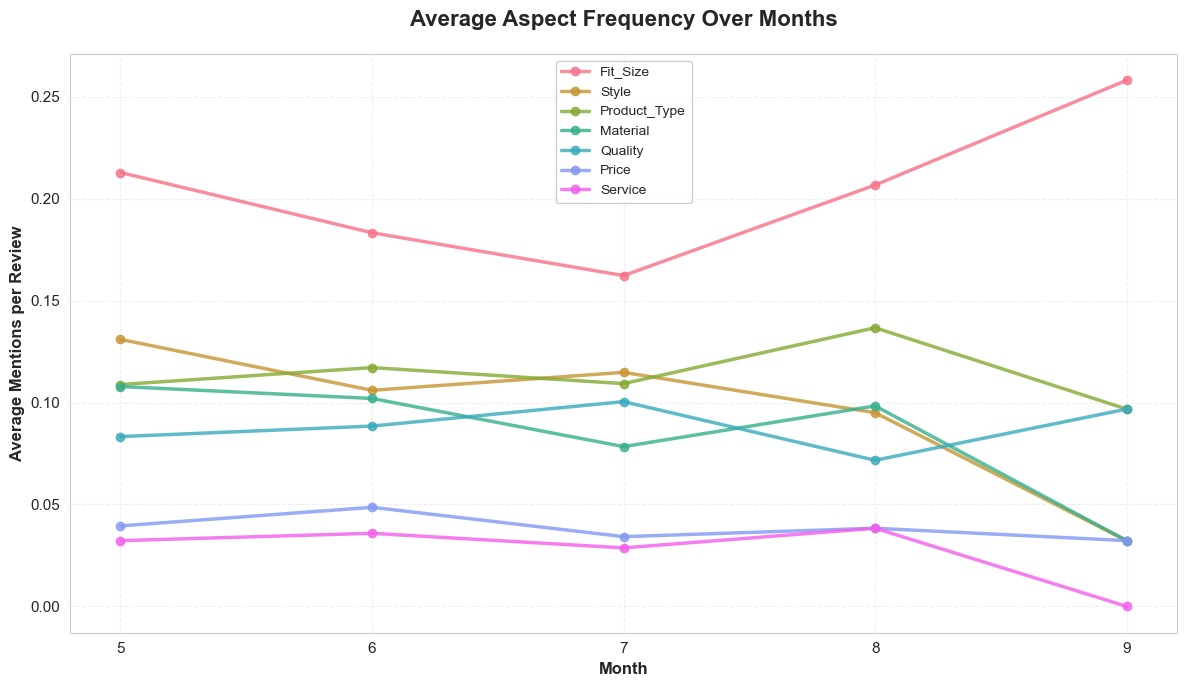

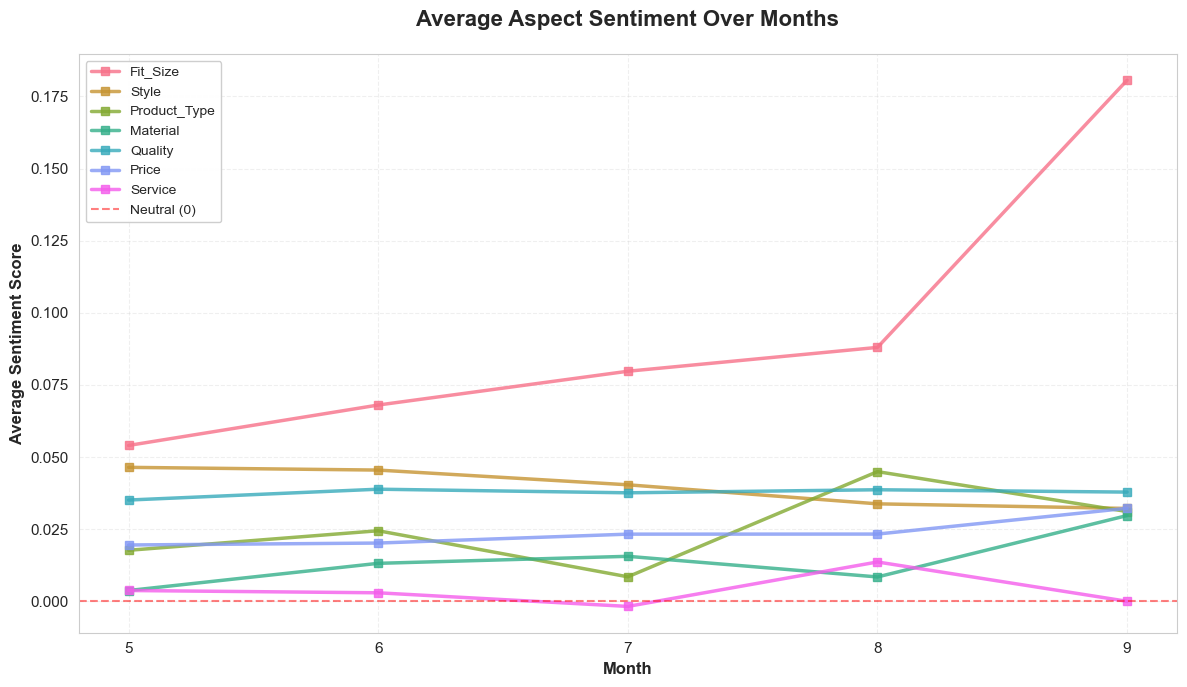

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 11

# Color palette
colors = sns.color_palette("husl", len(aspect_cols_exist))

# Plot 1: Average Aspect Frequency Over Months
fig, ax = plt.subplots(figsize=(12, 7))
for idx, col in enumerate(aspect_cols_exist):
    ax.plot(monthly_exist['month'], monthly_exist[col], 
            label=col.replace('_exist', ''), 
            marker='o', linewidth=2.5, markersize=6, 
            color=colors[idx], alpha=0.8)

ax.set_title('Average Aspect Frequency Over Months', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Mentions per Review', fontsize=12, fontweight='bold')
ax.set_xticks(range(5, 10))
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10, framealpha=0.95)
plt.tight_layout()
plt.show()


# Plot 2: Average Aspect Sentiment Over Months
fig, ax = plt.subplots(figsize=(12, 7))
for idx, col in enumerate(aspect_cols_score):
    ax.plot(monthly_exist['month'], monthly_score[col], 
            label=col.replace('_score', ''), 
            marker='s', linewidth=2.5, markersize=6, 
            color=colors[idx], alpha=0.8)

ax.set_title('Average Aspect Sentiment Over Months', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Sentiment Score', fontsize=12, fontweight='bold')
ax.set_xticks(range(5, 10))
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='Neutral (0)')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(loc='best', fontsize=10, framealpha=0.95)
plt.tight_layout()
plt.show()


#### 3. Store-wise comparison

In [76]:
top_stores = merged_use['store'].value_counts().nlargest(10).index
df_top = merged_use[merged_use['store'].isin(top_stores)]

aspect_cols_exist = [c for c in merged_use.columns if c.endswith('_exist')]
aspect_cols_score = [c for c in merged_use.columns if c.endswith('_score')]

store_exist = df_top.groupby('store')[aspect_cols_exist].mean().reset_index()
store_score = df_top.groupby('store')[aspect_cols_score].mean().reset_index()

store_summary = pd.merge(store_exist, store_score, on='store', suffixes=('_freq', '_sent'))



In [77]:
store_summary

,store,Fit_Size_exist,Style_exist,Product_Type_exist,Material_exist,Quality_exist,Price_exist,Service_exist,Fit_Size_score,Style_score,Product_Type_score,Material_score,Quality_score,Price_score,Service_score
0,CAXMAN,0.240000,0.040000,0.120000,0.000000,0.040000,0.040000,0.040000,-0.025976,0.039948,-0.029264,0.000000,0.039980,0.033048,0.039980
1,COOFANDY,0.228571,0.057143,0.028571,0.028571,0.171429,0.028571,0.000000,0.170251,-0.012629,0.027854,-0.027540,-0.131151,-0.024320,0.000000
2,Casio,0.051948,0.129870,0.090909,0.025974,0.064935,0.064935,0.000000,0.047584,0.115668,0.088123,0.012979,0.039532,-0.000078,0.000000
3,Copper Fit,0.258065,0.000000,0.193548,0.032258,0.096774,0.000000,0.032258,-0.007279,0.000000,0.079490,0.023239,-0.027006,0.000000,-0.031813
4,Generic,0.175439,0.140351,0.157895,0.087719,0.052632,0.035088,0.052632,0.017067,0.001502,0.041309,0.001088,0.034042,0.000416,0.017530
5,HIGHDAYS,0.416667,0.194444,0.027778,0.250000,0.055556,0.055556,0.027778,0.244197,0.160872,0.027742,0.190297,0.043861,0.054164,0.027636
6,NELEUS,0.441379,0.089655,0.006897,0.179310,0.055172,0.013793,0.027586,0.113465,0.013270,0.006867,0.049293,0.023951,0.012689,0.023563
7,Nike,0.386364,0.068182,0.113636,0.068182,0.000000,0.022727,0.000000,0.070194,0.023234,0.046527,-0.003270,0.000000,-0.020000,0.000000
8,OrthoComfoot,0.173228,0.086614,0.188976,0.023622,0.094488,0.031496,0.039370,0.071393,0.041686,0.082661,-0.006394,0.006187,0.014540,0.011017
9,Sidelinx,0.058824,0.078431,0.274510,0.019608,0.117647,0.098039,0.000000,0.058218,0.077422,0.098480,0.019586,0.115880,-0.001870,0.000000


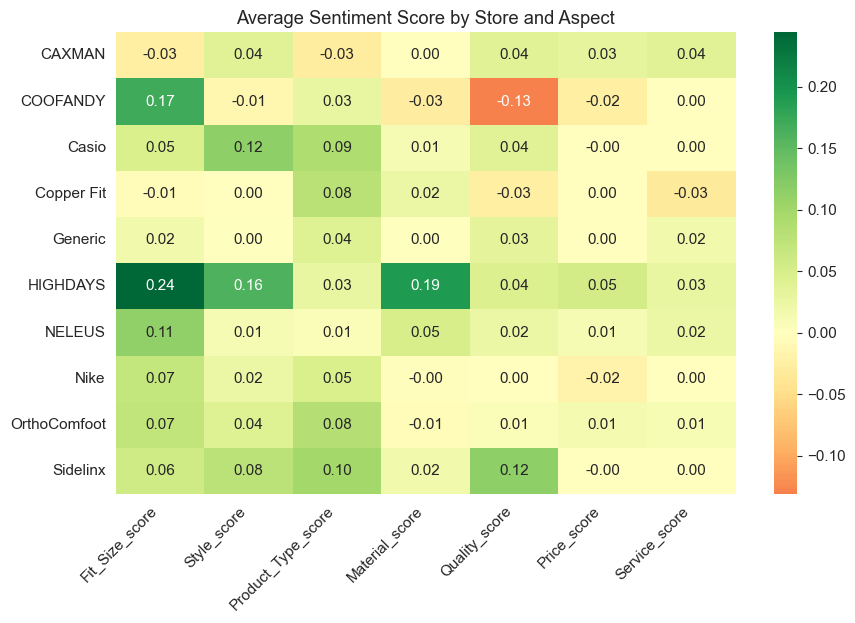

In [78]:

plt.figure(figsize=(10,6))
sns.heatmap(
    store_score.set_index('store'),
    cmap='RdYlGn', center=0, annot=True, fmt=".2f",   
)
plt.title("Average Sentiment Score by Store and Aspect")
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.show()


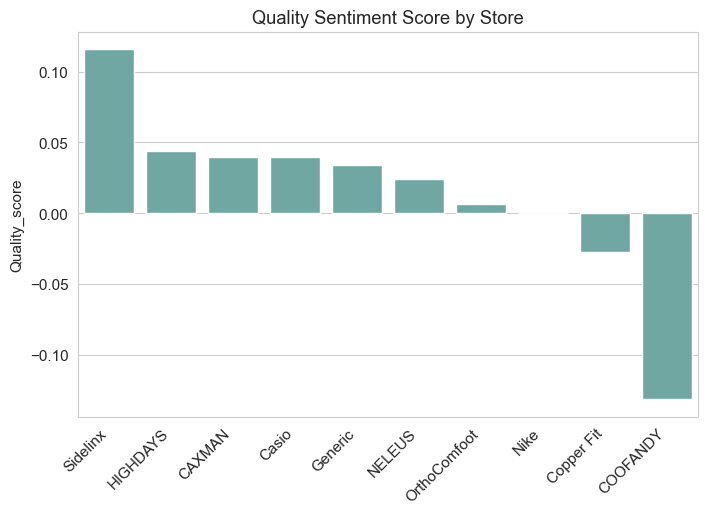

In [79]:
aspect = 'Quality'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()


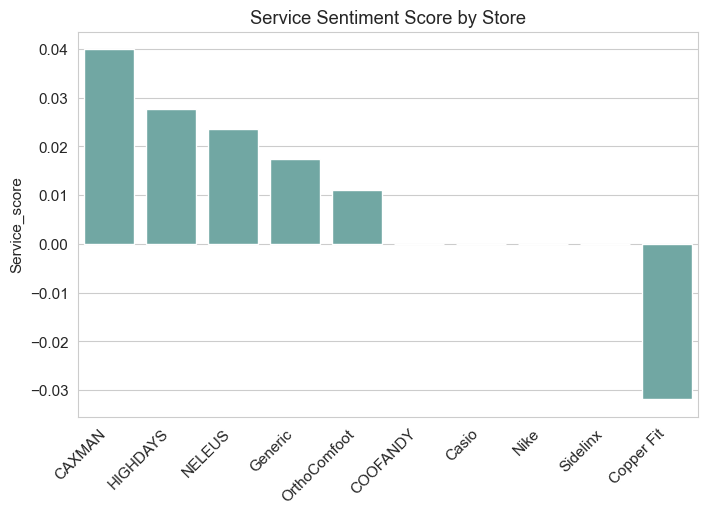

In [80]:
aspect = 'Service'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

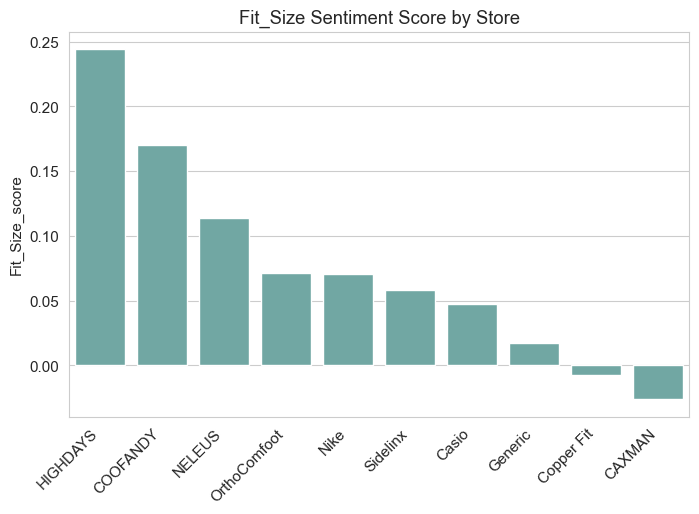

In [81]:
aspect = 'Fit_Size'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

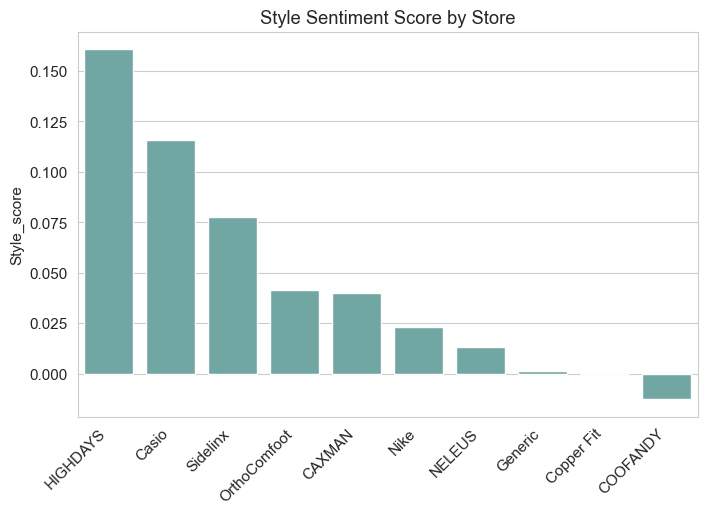

In [82]:
aspect = 'Style'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

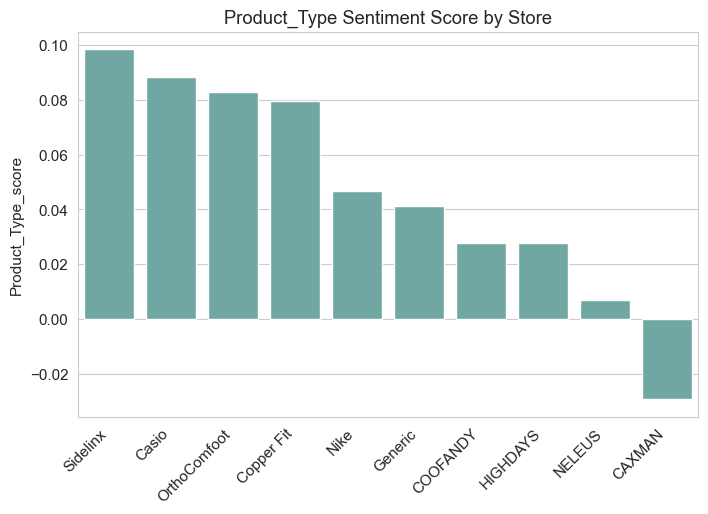

In [83]:
aspect = 'Product_Type'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

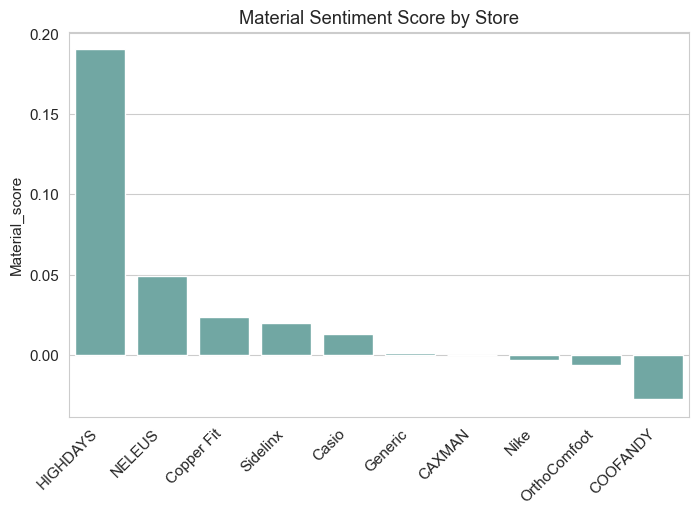

In [84]:
aspect = 'Material'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

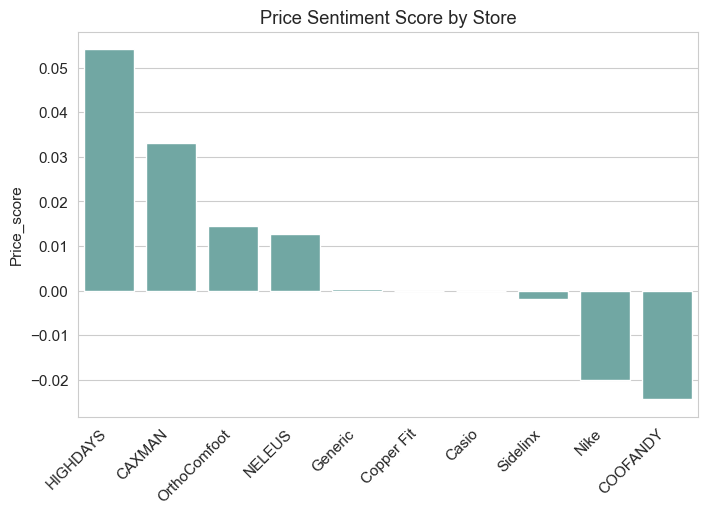

In [85]:
aspect = 'Price'
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'{aspect}_score',
    color='#68b0ab',
    order=store_score.sort_values(f'{aspect}_score', ascending=False)['store']
)
plt.title(f"{aspect} Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

In [86]:
score_cols = [c for c in store_score.columns if c.endswith('_score')]
store_score['avg_sentiment'] = store_score[score_cols].mean(axis=1)


In [87]:
store_score.sort_values('avg_sentiment', ascending=False).head()


,store,Fit_Size_score,Style_score,Product_Type_score,Material_score,Quality_score,Price_score,Service_score,avg_sentiment
5,HIGHDAYS,0.244197,0.160872,0.027742,0.190297,0.043861,0.054164,0.027636,0.106967
9,Sidelinx,0.058218,0.077422,0.098480,0.019586,0.115880,-0.001870,0.000000,0.052531
2,Casio,0.047584,0.115668,0.088123,0.012979,0.039532,-0.000078,0.000000,0.043401
6,NELEUS,0.113465,0.013270,0.006867,0.049293,0.023951,0.012689,0.023563,0.034728
8,OrthoComfoot,0.071393,0.041686,0.082661,-0.006394,0.006187,0.014540,0.011017,0.031584


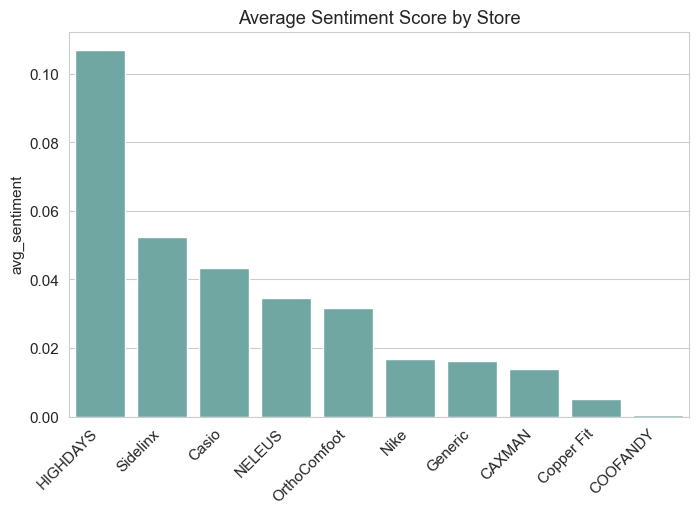

In [88]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=store_score,
    x='store', y=f'avg_sentiment',
    color='#68b0ab',
    order=store_score.sort_values('avg_sentiment', ascending=False)['store']
)
plt.title("Average Sentiment Score by Store")
plt.xlabel('')
plt.xticks(rotation=45, ha='right')
plt.show()

#### RQ1: Which text feature aspects most strongly influence star ratings

apply linear regression as a baseline model

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

aspect_features = [
    'Fit_Size_exist', 'Fit_Size_score',
    'Style_exist', 'Style_score',
    'Product_Type_exist', 'Product_Type_score',
    'Material_exist', 'Material_score',
    'Quality_exist', 'Quality_score',
    'Price_exist', 'Price_score',
    'Service_exist', 'Service_score'
]

target = 'rating'

X = merged_use[aspect_features].copy()
y = merged_use[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


linreg = LinearRegression()

linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:.4f}")
print(f"Linear Regression R²: {r2:.4f}")

Linear Regression RMSE: 1.4134
Linear Regression R²: 0.1914


R_square is pretty low, considering using machine learning models to improve performance.

Extreme Gradient Boosting (XGBoost) - an open-source machine learning software library that provides an efficient, flexible, and portable implementation of the gradient boosting algorithm. 

XGBRegressor implements the XGBoost algorithm, known for its efficiency and performance in machine learning. It builds an ensemble of decision trees sequentially, where each new tree corrects the errors of the preceding ones.

In [90]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap



In [91]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [92]:
# tried some param tuning here

model = XGBRegressor(
    n_estimators=400,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [93]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

print("Training Set Performance:")
print(f"  RMSE: {rmse_train:.4f}")
print(f"  R²: {r2_train:.4f}")
print("\nTest Set Performance:")
print(f"  RMSE: {rmse_test:.4f}")
print(f"  R²: {r2_test:.4f}")



Training Set Performance:
  RMSE: 1.2452
  R²: 0.3291

Test Set Performance:
  RMSE: 1.4030
  R²: 0.2032


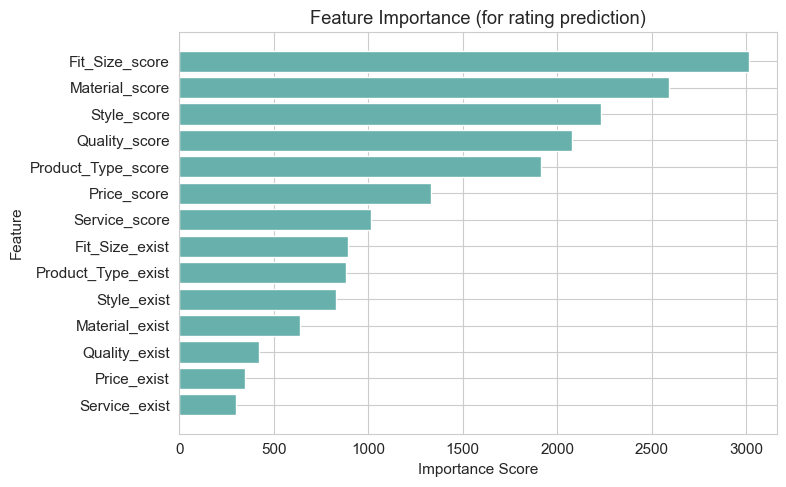

In [101]:
xgb_importance = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'feature': list(xgb_importance.keys()),
    'importance': list(xgb_importance.values())
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df['feature'], importance_df['importance'], color = '#68b0ab')
plt.gca().invert_yaxis()
plt.title('Feature Importance (for rating prediction)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [95]:

importance_df['aspect'] = importance_df['feature'].str.replace('_exist|_score', '', regex=True)
importance_summary = importance_df.groupby('aspect')['importance'].sum().sort_values(ascending=False)
print(importance_summary)


aspect
Fit_Size        3907.0
Material        3231.0
Style           3062.0
Product_Type    2797.0
Quality         2502.0
Price           1680.0
Service         1314.0
Name: importance, dtype: float64


#### RQ2: Which text feature aspects mostly predict review helpfulness(0-1 binary)

In [96]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

aspect_features = [
    'Fit_Size_exist', 'Fit_Size_score',
    'Style_exist', 'Style_score',
    'Product_Type_exist', 'Product_Type_score',
    'Material_exist', 'Material_score',
    'Quality_exist', 'Quality_score',
    'Price_exist', 'Price_score',
    'Service_exist', 'Service_score'
]

meta_features = ['verified_purchase']
features = aspect_features + meta_features
target = 'helpful_binary'

X = merged_use[features].copy()
y = merged_use[target].astype(int).copy()

X = X.fillna(0)
for c in X.columns:
    if X[c].dtype == 'bool':
        X[c] = X[c].astype(int)

pos = y.sum()
neg = len(y) - pos
print(f"Positive(helpful=1): {pos}, Negative(helpful=0): {neg}, ratio pos/neg = {pos/neg:.3f}")

scale_pos_weight = neg / (pos + 1e-9)
print(scale_pos_weight)


Positive(helpful=1): 503, Negative(helpful=0): 4366, ratio pos/neg = 0.115
8.679920477119921


In [97]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model_2 = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    scale_pos_weight=scale_pos_weight  
)

model_2.fit(X_train, y_train)

/opt/miniconda3/envs/compss211/lib/python3.11/site-packages/xgboost/training.py:199: UserWarning: [19:16:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [98]:

y_proba = model_2.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("ROC AUC: {:.4f}".format(roc_auc))
print("F1: {:.4f}, Precision: {:.4f}, Recall: {:.4f}".format(f1, precision, recall))



ROC AUC: 0.5291
F1: 0.1441, Precision: 0.1259, Recall: 0.1683


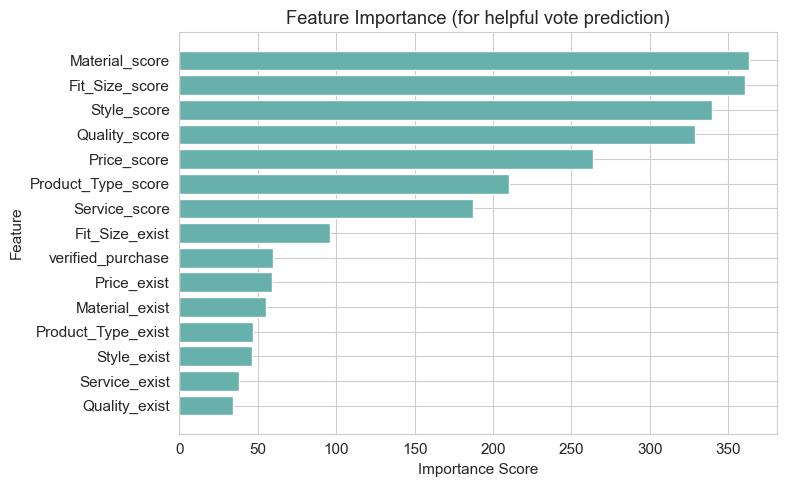

In [102]:
xgb_importance_2 = model_2.get_booster().get_score(importance_type='weight')
importance_df_2 = pd.DataFrame({
    'feature': list(xgb_importance_2.keys()),
    'importance': list(xgb_importance_2.values())
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance_df_2['feature'], importance_df_2['importance'], color = '#68b0ab')
plt.gca().invert_yaxis()
plt.title('Feature Importance (for helpful vote prediction)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [100]:
importance_df_2['aspect'] = importance_df_2['feature'].str.replace('_exist|_score', '', regex=True)
importance_summary = importance_df_2.groupby('aspect')['importance'].sum().sort_values(ascending=False)
print(importance_summary)

aspect
Fit_Size             457.0
Material             418.0
Style                386.0
Quality              363.0
Price                323.0
Product_Type         257.0
Service              225.0
verified_purchase     60.0
Name: importance, dtype: float64
